<a href="https://colab.research.google.com/github/MaLuisa7/Art-culo-ML/blob/main/stock_price_prediction_ML_20230312.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción del movimiento de la acción de bolsa "S & P 500"**

## 1. Carga de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib


import warnings
warnings.filterwarnings('ignore')
! pip install yfinance
import yfinance as yf
from datetime import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Carga de Datos

Interesa conocer como se ha comportado la acción en los últimos 23 años.

In [2]:
ticker = yf.Ticker('SPY')
end_date = '2023-01-23'
start_date = '2000-01-23'
sp500 = ticker.history(start=start_date,end=end_date)
sp500.drop(columns = ['Stock Splits',	'Capital Gains','Dividends'], inplace = True)
print("Shape of SP 500 data is:", sp500.shape)
sp500.head(2)

Shape of SP 500 data is: (5786, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2000-01-24 00:00:00-05:00,95.452131,95.575004,91.356352,91.970718,7896900
2000-01-25 00:00:00-05:00,92.083430,93.015221,91.090203,93.015221,9942500


In [6]:
sp500['day'] = sp500.index.day
sp500['month'] = sp500.index.month
sp500['year'] = sp500.index.year
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500['is_quarter_end'] = np.where(sp500['month']%3==0,1,0)
sp500['open-close']  = sp500['Open'] - sp500['Close']
sp500['low-high']  = sp500['Low'] - sp500['High']
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]
sp500.head(3)

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,is_quarter_end,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-24 00:00:00-05:00,95.452131,95.575004,91.356352,91.970718,7896900,24,1,2000,93.015221,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-25 00:00:00-05:00,92.083430,93.015221,91.090203,93.015221,9942500,25,1,2000,92.277954,0,...,1.005646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-26 00:00:00-05:00,92.400828,92.759208,91.806939,92.277954,5158100,26,1,2000,91.909309,0,...,0.996021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Análisis Descriptivo

Comportamiento del cierre del precio

Text(0.5, 0, 'Años')

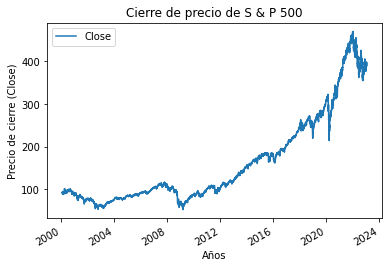

In [3]:
sp500.plot.line(y="Close", use_index=True)
plt.title("Cierre de precio de S & P 500")
plt.ylabel("Precio de cierre (Close)")
plt.xlabel("Años")

Histogramas de las variables de apertura (Open) y  cierre (Close) del precio asi como su valor más alto (High) y bajo (Low). 

In [45]:
sp500.shape

(4785, 23)

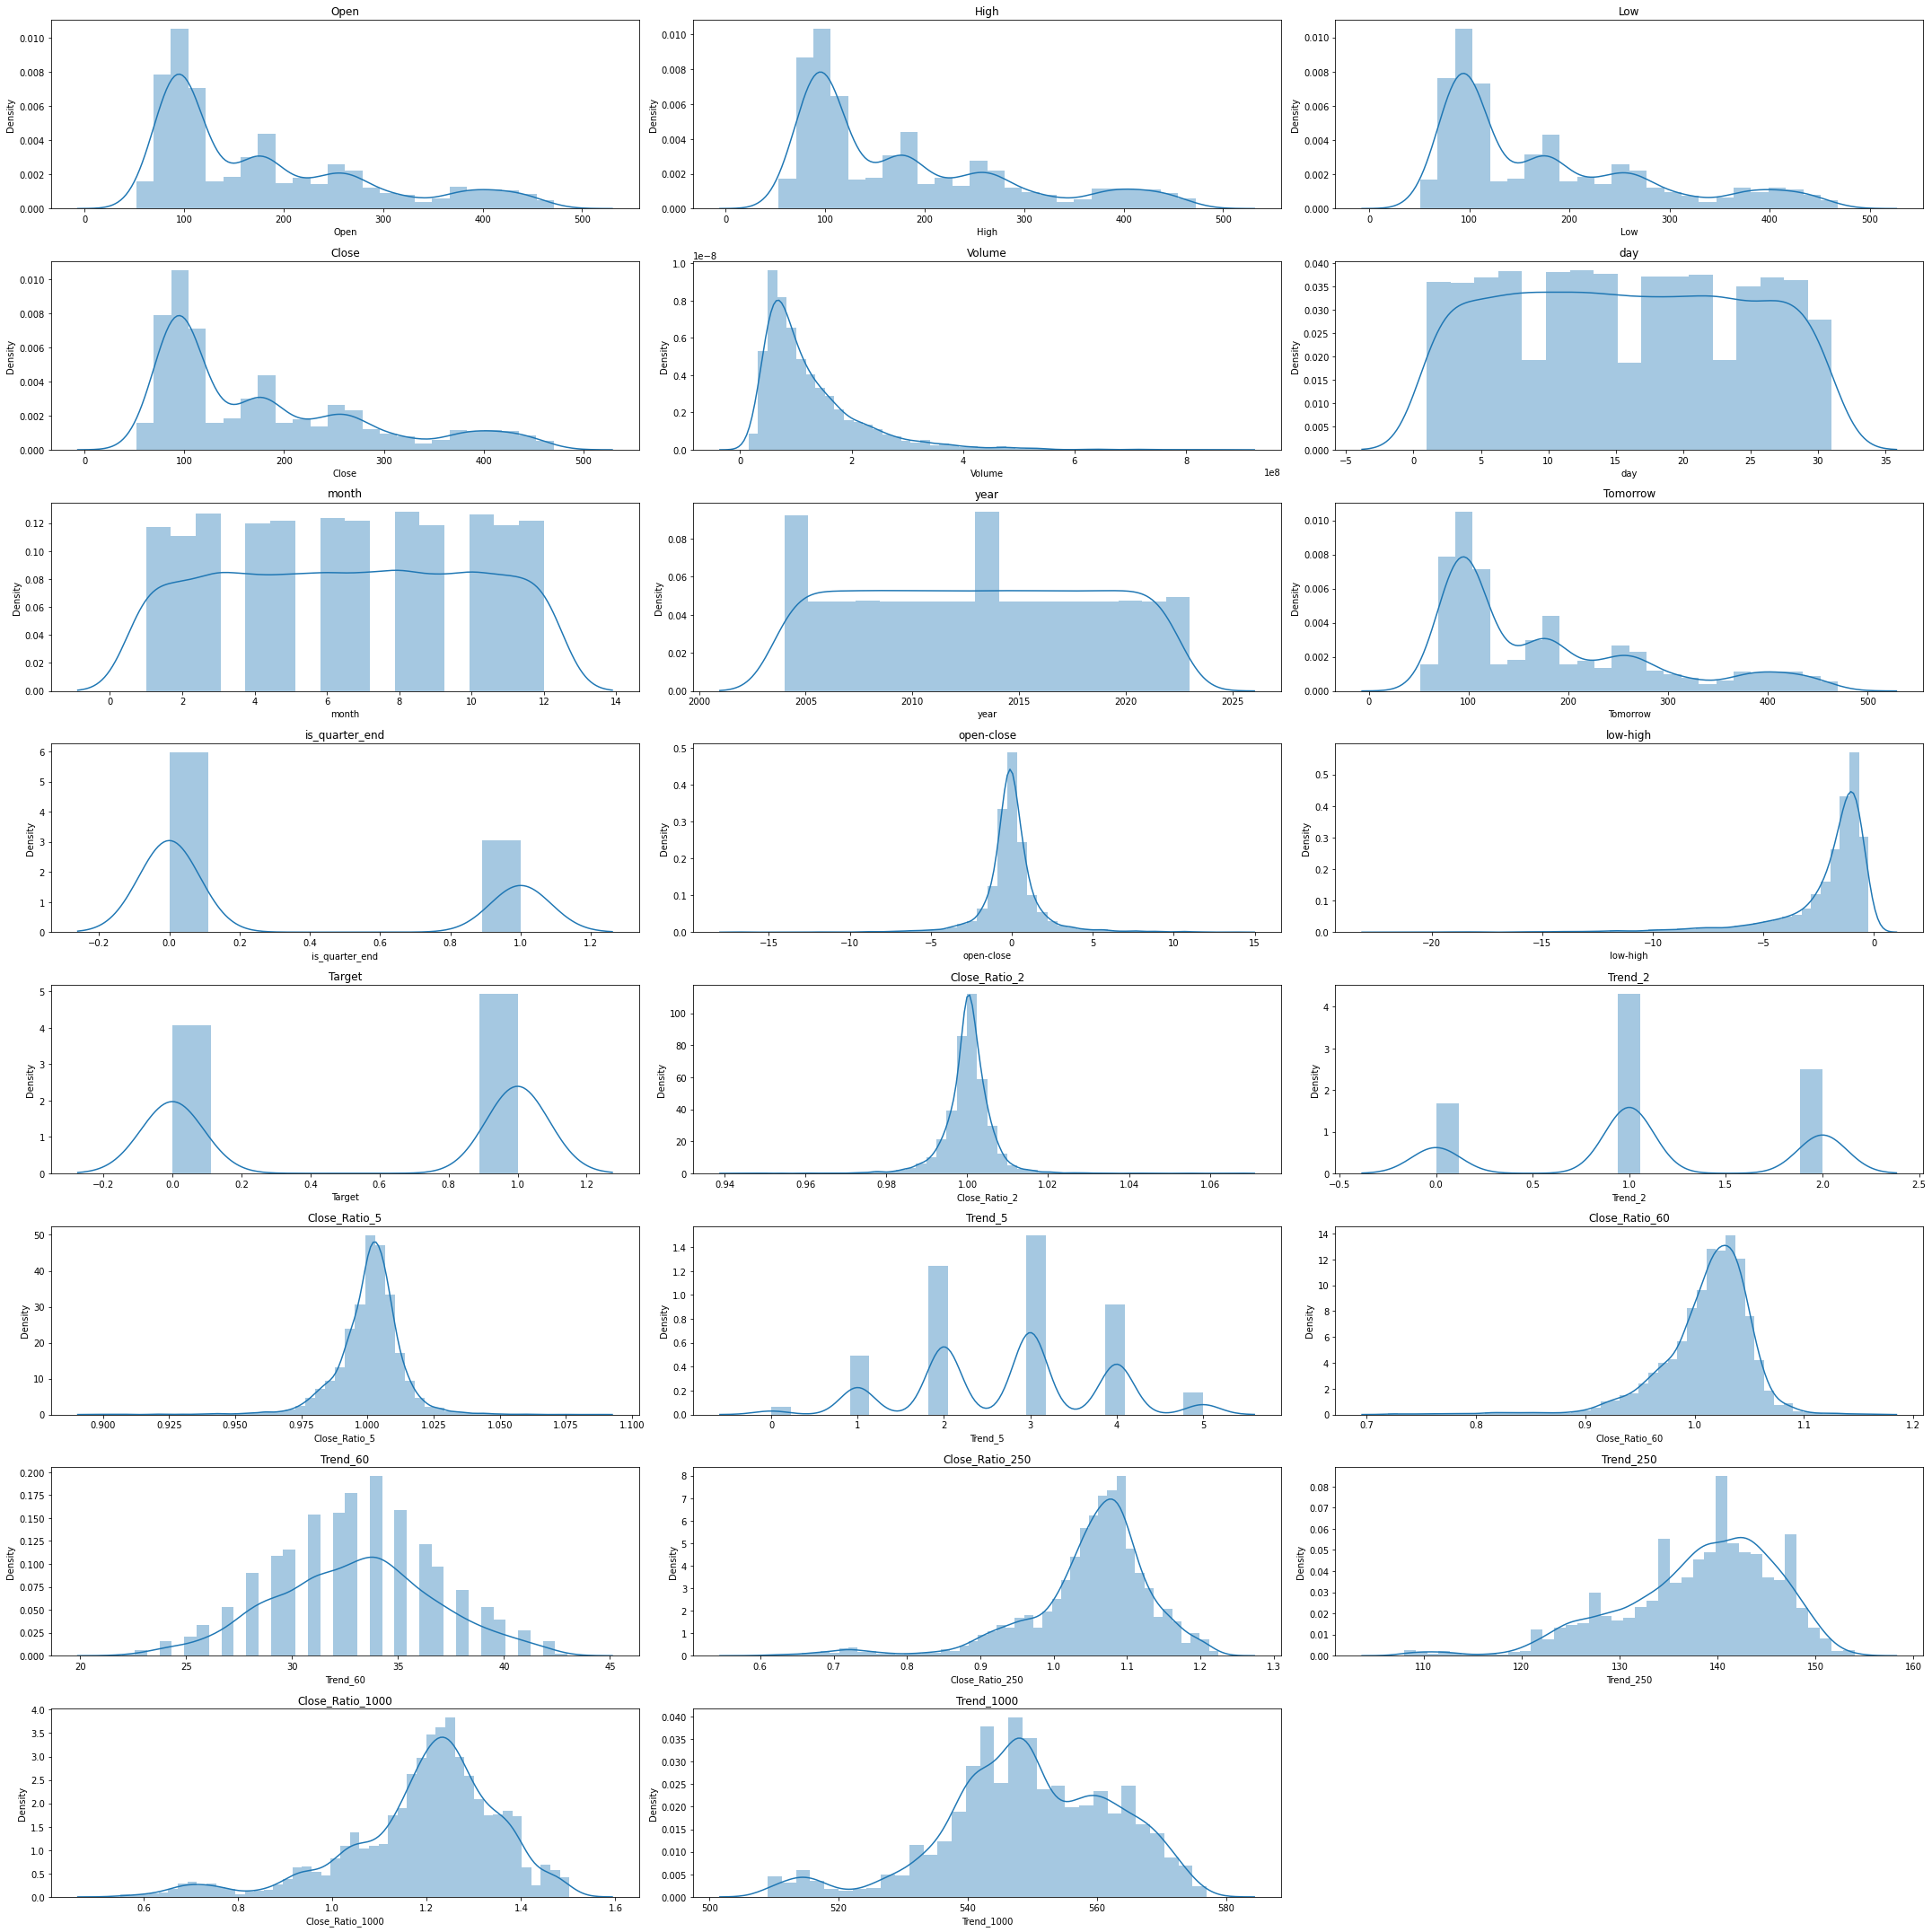

In [54]:
features =sp500.columns.to_list()  
plt.subplots(figsize=(30,30))
for i, col in enumerate(features):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  sns.distplot(sp500[col]).set(title=sp500[col].name)
plt.show()

* Se observa que las distribuciones tanto para Open, High , Low y Close de la acción S&P 500 se comportan similarmente. 

* Para la variable volumen tiene una distribución muy parecida a la de una Chi cuadrada.

Diagrama de cajas y bigote de las variables de apertura (Open) y  cierre (Close) del precio asi como su valor más alto (High) y bajo (Low). 

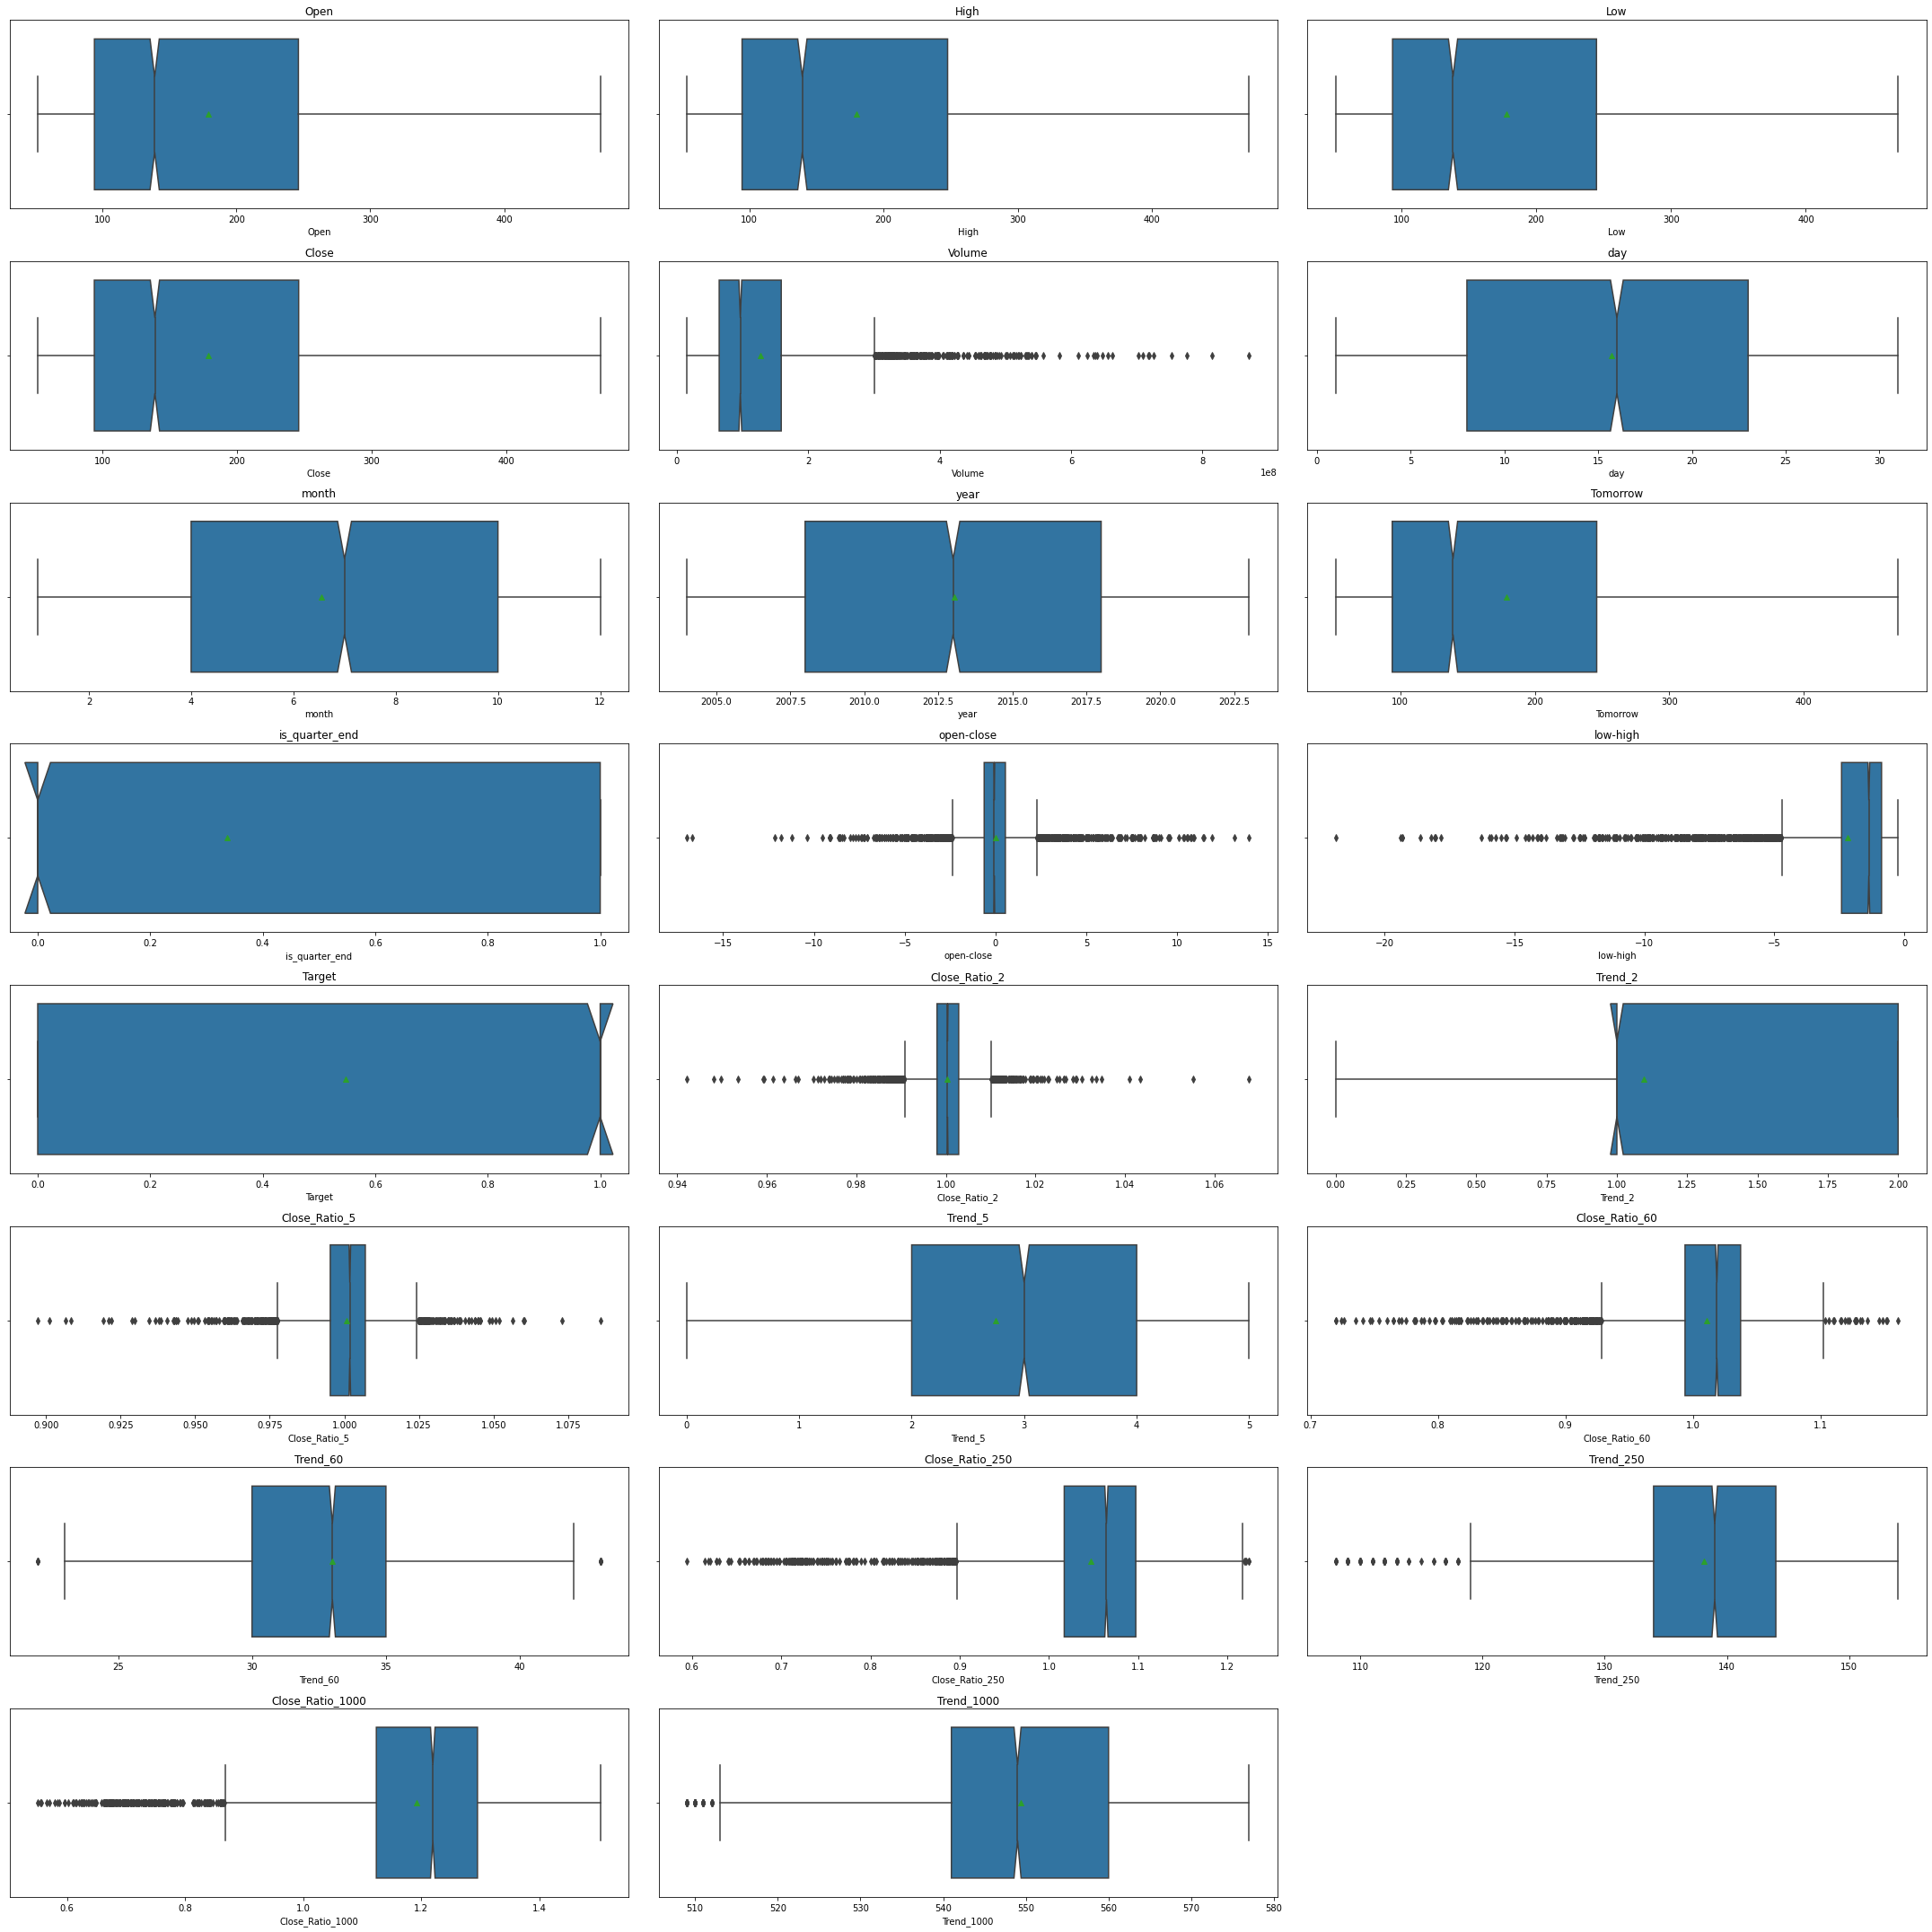

In [56]:
features =sp500.columns.to_list()  
plt.subplots(figsize=(30,30))
for i, col in enumerate(features):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  sns.boxplot(sp500[col], showmeans=True, notch=True).set(title=sp500[col].name)
plt.show()

Es posible concluir que las variables Open, High, Low y Close se comportan similarmente, mientras que la variable volumen se concentra en el valor 1.

In [59]:
sp500.columns.to_list()  

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'day',
 'month',
 'year',
 'Tomorrow',
 'is_quarter_end',
 'open-close',
 'low-high',
 'Target',
 'Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

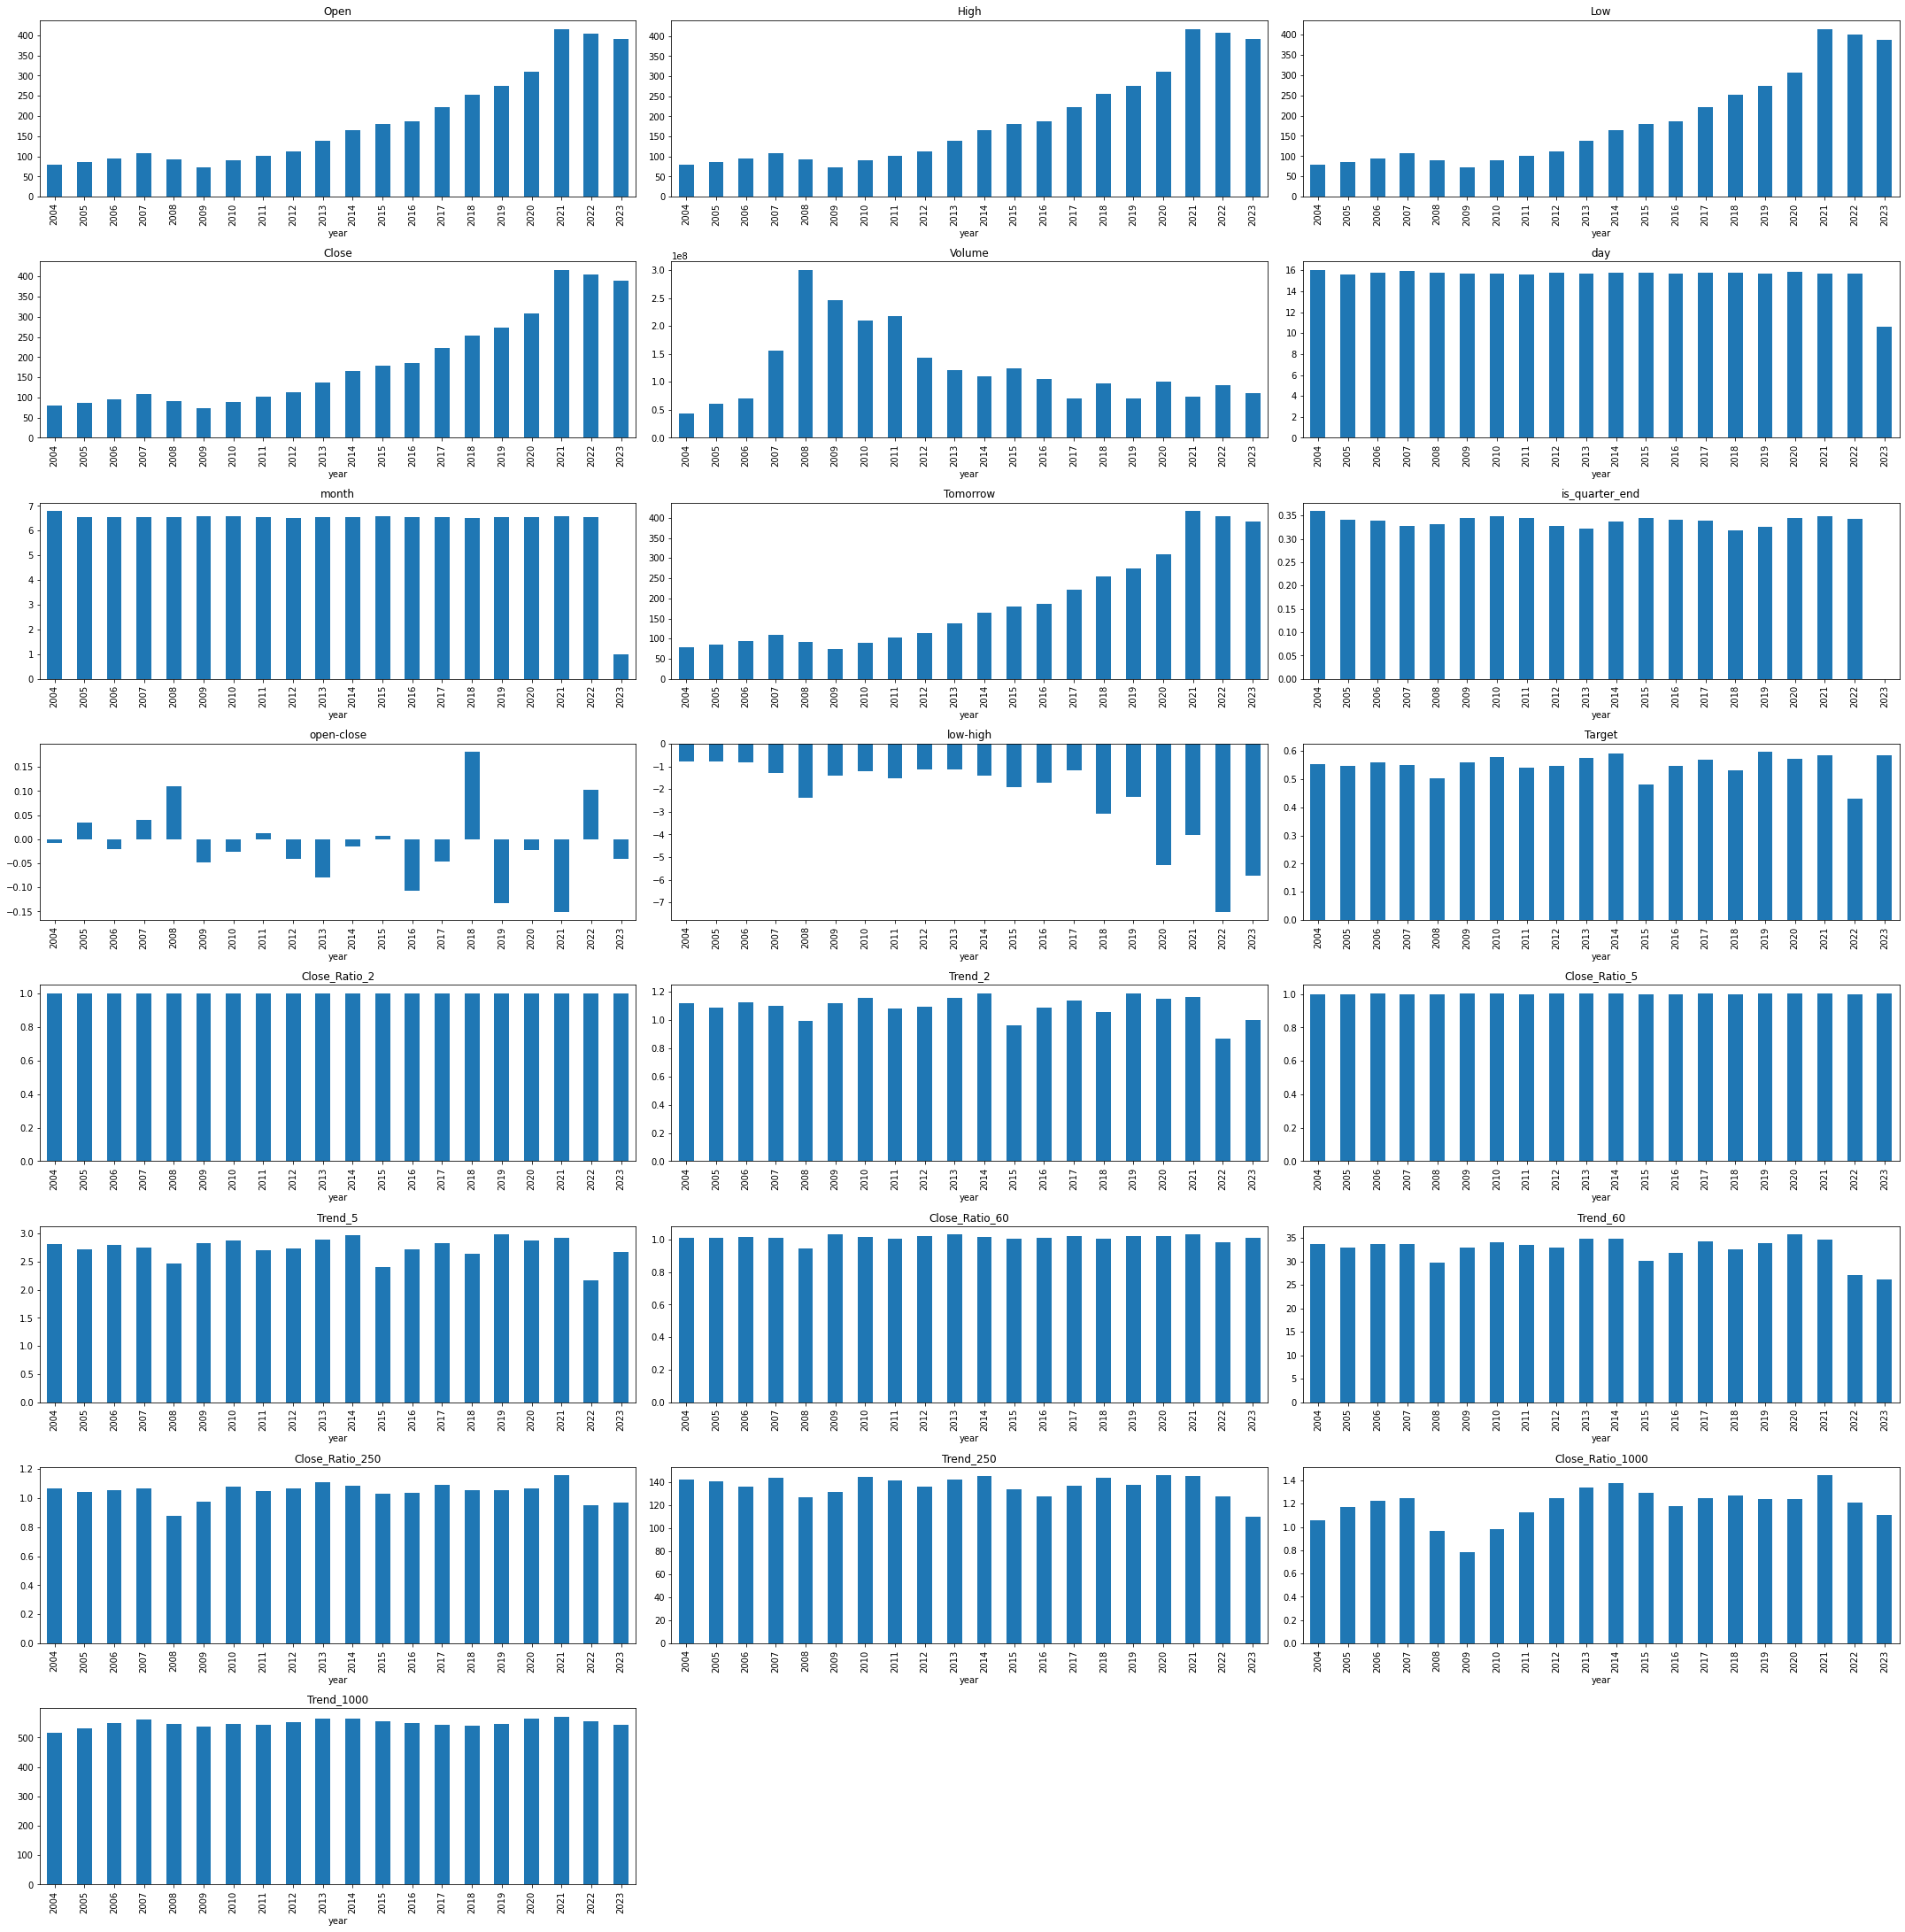

In [62]:
features_2 = ['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month',  'Tomorrow', 'is_quarter_end',
 'open-close', 'low-high', 'Target', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60',
 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']

data_grouped = sp500.groupby('year').mean()
plt.subplots(figsize=(30,30))
for i, col in enumerate(features_2):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  data_grouped[col].plot.bar().set(title=sp500[col].name)
plt.show()

In [63]:
sp500.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,open-close,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
is_quarter_end,,,,,,,,,,,,,,,,,,,,,
0,178.873471,179.898606,177.773963,178.926640,1.261295e+08,15.712618,6.091798,2013.069085,179.026596,-0.053169,...,1.000227,1.119243,1.000935,2.787066,1.011538,32.974448,1.048239,138.161830,1.193426,549.351735
1,179.227912,180.271275,178.023169,179.156701,1.293409e+08,15.772136,7.435913,2012.993808,179.156653,0.071211,...,1.000048,1.052012,1.000226,2.654489,1.008785,32.988854,1.045676,138.082972,1.189217,549.373994


Descriptivos de las variables

In [64]:
sp500.describe()

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,is_quarter_end,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
count,4785.000000,4785.000000,4785.000000,4785.000000,4.785000e+03,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,...,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000
mean,178.993100,180.024386,177.858073,179.004289,1.272134e+08,15.732706,6.545455,2013.043678,179.070492,0.337513,...,1.000167,1.096552,1.000696,2.742320,1.010609,32.979310,1.047374,138.135214,1.192005,549.359248
std,106.557946,107.192367,105.844878,106.562136,9.350038e+07,8.753345,3.427168,5.484203,106.598450,0.472911,...,0.006071,0.695391,0.012245,1.080892,0.043370,3.823088,0.089195,7.795590,0.164510,13.405976
min,51.835077,53.398904,51.186675,51.957134,1.527000e+07,1.000000,1.000000,2004.000000,51.957134,0.000000,...,0.942122,0.000000,0.897272,0.000000,0.719865,22.000000,0.594101,108.000000,0.550481,509.000000
25%,94.135785,94.642710,93.407917,94.017105,6.472440e+07,8.000000,4.000000,2008.000000,94.024323,0.000000,...,0.998000,1.000000,0.995280,2.000000,0.993682,30.000000,1.017127,134.000000,1.123836,541.000000
50%,139.089206,139.550450,138.258907,139.072418,9.687800e+07,16.000000,7.000000,2013.000000,139.181458,0.000000,...,1.000341,1.000000,1.001834,3.000000,1.018600,33.000000,1.064399,139.000000,1.219438,549.000000
75%,246.363056,247.730350,244.692262,245.940353,1.591322e+08,23.000000,10.000000,2018.000000,246.018250,1.000000,...,1.002841,2.000000,1.007022,4.000000,1.037226,35.000000,1.097309,144.000000,1.295111,560.000000
max,471.569561,472.317438,468.459983,470.083649,8.710263e+08,31.000000,12.000000,2023.000000,470.083649,1.000000,...,1.067685,2.000000,1.085719,5.000000,1.160691,43.000000,1.224336,154.000000,1.502901,577.000000


Matriz de correlación

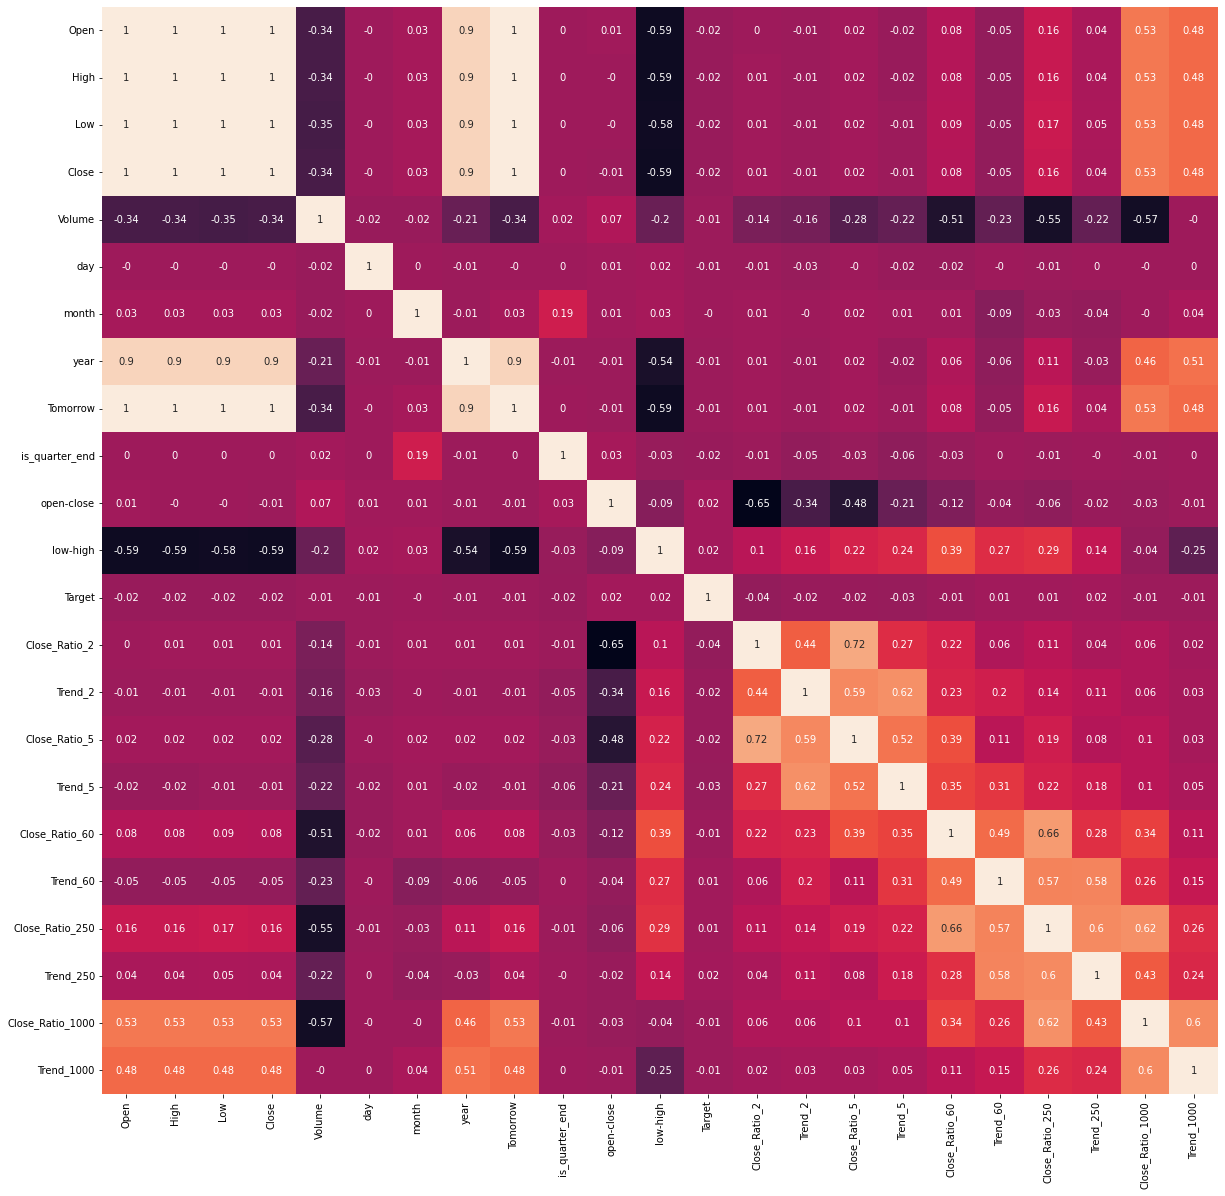

In [67]:
plt.figure(figsize=(20, 20))
 
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sns.heatmap(round(sp500.corr(),2) , annot=True, cbar=False)
plt.show()

Se agregan características que contribuyen a que los datos que se analizan sean más significativos

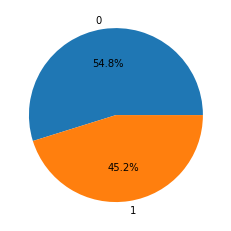

In [68]:
plt.pie(sp500['Target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

In [69]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

predictors =['Open', 'High', 'Low', 'Close',
 'Volume', 'day', 'month', 'year', 'Tomorrow', 'is_quarter_end', 'open-close', 'low-high',
 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [70]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(model, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(sp500[predictors], sp500.Target)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [24]:
sfs1.subsets_

{1: {'feature_idx': (18,),
  'cv_scores': array([0.70282132]),
  'avg_score': 0.70282131661442,
  'feature_names': ('Close_Ratio_250',)},
 2: {'feature_idx': (14, 18),
  'cv_scores': array([0.72371996]),
  'avg_score': 0.7237199582027168,
  'feature_names': ('Close_Ratio_5', 'Close_Ratio_250')},
 3: {'feature_idx': (8, 14, 18),
  'cv_scores': array([0.74399164]),
  'avg_score': 0.7439916405433646,
  'feature_names': ('Tomorrow', 'Close_Ratio_5', 'Close_Ratio_250')},
 4: {'feature_idx': (3, 8, 14, 18),
  'cv_scores': array([0.85120167]),
  'avg_score': 0.8512016718913271,
  'feature_names': ('Close', 'Tomorrow', 'Close_Ratio_5', 'Close_Ratio_250')},
 5: {'feature_idx': (2, 3, 8, 14, 18),
  'cv_scores': array([0.85705329]),
  'avg_score': 0.8570532915360501,
  'feature_names': ('Low',
   'Close',
   'Tomorrow',
   'Close_Ratio_5',
   'Close_Ratio_250')},
 6: {'feature_idx': (1, 2, 3, 8, 14, 18),
  'cv_scores': array([0.8539185]),
  'avg_score': 0.8539184952978056,
  'feature_names': ('Hi

SE observa que el subconjunto que aporta mejor informacion al modelo de random forest es el 5:

* 'feature_idx': (2, 3, 8, 14, 18),
* 'cv_scores': array([0.85705329]),
* 'avg_score': 0.8570532915360501,
* 'feature_names': (
  * 'Low',
  * 'Close',
  * 'Tomorrow',
  * 'Close_Ratio_5',
  * 'Close_Ratio_250')


In [32]:
subset_sel = ['Low','Close','Tomorrow','Close_Ratio_5','Close_Ratio_250']

In [33]:
def predict(train, test, predictors, model):
    model.fit(train[subset_sel], train["Target"])
    preds = model.predict(test[subset_sel])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [39]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [40]:
predictions = backtest(sp500, model, predictors)

In [41]:
predictions["Predictions"].value_counts()


0    1178
1    1107
Name: Predictions, dtype: int64

In [43]:
from sklearn.metrics import precision_score
precision_score(predictions["Target"], predictions["Predictions"])


0.5727190605239386

In [159]:
predictions["Target"].value_counts() / predictions.shape[0]


0    0.571429
1    0.428571
Name: Target, dtype: float64

In [44]:
predictions

,Target,Predictions
Date,,
2013-12-20 00:00:00-05:00,1,0
2013-12-23 00:00:00-05:00,1,0
2013-12-24 00:00:00-05:00,1,0
2013-12-26 00:00:00-05:00,0,0
2013-12-27 00:00:00-05:00,0,0
...,...,...
2023-01-12 00:00:00-05:00,1,1
2023-01-13 00:00:00-05:00,0,1
2023-01-17 00:00:00-05:00,0,0


In [77]:
import sklearn
cf = sklearn.metrics.confusion_matrix(predictions.Target, predictions.Predictions)
cf

array([[567, 473],
       [611, 634]])

In [78]:
(567+634)/(np.sum(cf))

0.5256017505470459

# Diseño de Experimentos (DoE)

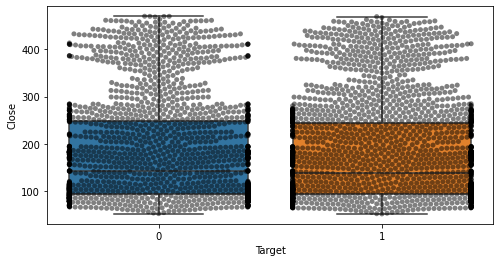

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x="Target", y="Close", data=sp500, ax=ax)
sns.swarmplot(x="Target", y="Close", data=sp500, color='black', alpha = 0.5, ax=ax);

In [87]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=cda42d37db0f81720ce460d39606b378ea18a1672bd5f6450562ac9277c5293c
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

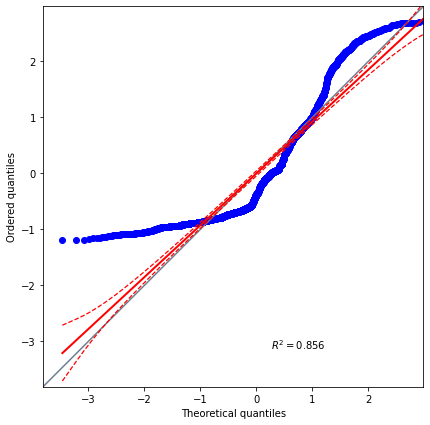

In [94]:
import pingouin as pg
plt.figure(figsize=(8, 7))
pg.qqplot(sp500.loc[sp500.Target==1, 'Close'], dist='norm')
 

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

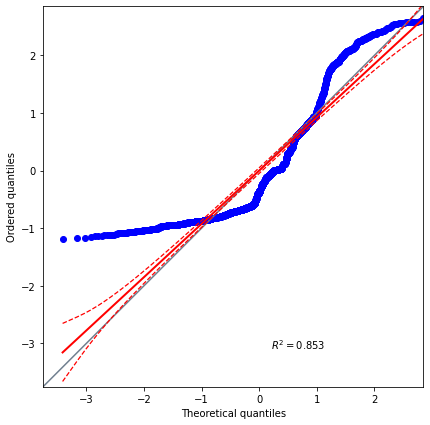

In [95]:
import pingouin as pg
plt.figure(figsize=(8, 7))
  
pg.qqplot(sp500.loc[sp500.Target==0, 'Close'], dist='norm' )
 

 

In [96]:
pg.normality(data=sp500, dv='Close', group='Target')


,W,pval,normal
Target,,,
0,0.852774,5.905913e-41,False
1,0.855504,6.866362e-44,False


Los datos nos siguen una distribución normal.

In [97]:
pg.homoscedasticity(data=sp500, dv='Close', group='Target', method='levene')

,W,pval,equal_var
levene,1.99008,0.158398,True


In [98]:
pg.pairwise_tukey(data=sp500, dv='Close', between='Target').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,1,181.115,177.265,3.85,3.095,1.244,0.214,0.036


In [100]:
# Test ANOVA de una vía (One-way ANOVA)
# ==============================================================================
pg.anova(data=sp500, dv='Close', between='Target', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,Target,1.756440e+04,1,17564.400372,1.546953,0.213647,0.000323
1,Within,5.430709e+07,4783,11354.190616,NaN,NaN,NaN


### Conclusión DoE

Es importante destacar que los datos no siguen una distribución normal. Sin embargo se continuo con el Diseño de Experimentos y se concluyo que como el  p-value es superior a 0.2136 es mayor al p-valor de 0.05, se rechaza $H_0$ si pvalor es menor a $\alpha$ si la hipótesis núla es que todos los grupos tienen la misma media, entonces los grupos no tienen la misma media.

[Literatura citada](https://www.cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python.html)
